In [53]:
#import packages - تحميل الحزم
#نحتاج حزمتي باندا ونمباي للتعامل مع البيانات
import pandas as pd 
import numpy as np

#to plot تحميل حزمة التخطيط البياني 
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#read the file
#لقرائة الملف - تأكد ان الملف بنفس المجلد
df = pd.read_csv('NSE-TATAGLOBAL11.csv')

#print the head
#يطبعلك أول عشر سطور بالملف
df.head(10)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
5,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914.0,7162.35
6,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859.0,11859.95
7,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909.0,5248.60
8,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368.0,5503.90
9,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509.0,7999.55


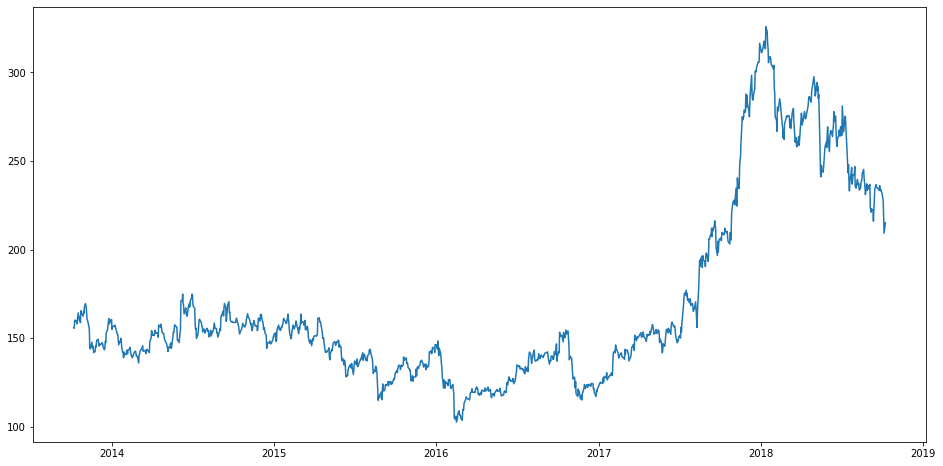

In [54]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d') #تحويل التاريخ إلى الصيغة المطلوبة 
df.index = df['Date'] # تحويل التاريخ إلى دليل

#plot التخطيط
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history') # تختار سعر الاغلاق للتخطيط

In [55]:
#importing required libraries
# MinMaxScaler لتوحيد البيانات
# Dense, Dropout, LSTM تصميم النموذج
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
# عمل اطار بيانات جديد
data = df.sort_index(ascending=True, axis=0) # ترتيب البيانات القديمة بناء على التاريخ
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close']) #اطار جديد
# حلقة تكرار لتخزين البيانات في الإطار الجديد
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date  # تحويل التاريخ إلى دليل
new_data.drop('Date', axis=1, inplace=True) # للتخلص من المتغير بما انا ما نحتاجه
#new_data.head(10)

In [56]:
#creating train and test sets
dataset = new_data.values #  نأخذ القيم فقط بدون التواريخ

train = dataset[0:987,:] # تدريب
valid = dataset[987:,:] # تحقق فيما بعد

#converting dataset into x_train and y_train تقسيم بيانات التدريب فقط 
scaler = MinMaxScaler(feature_range=(0, 1)) # توحيد البيانات
scaled_data = scaler.fit_transform(dataset)  

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [57]:
# create and fit the LSTM network # بناء النموذج
model = Sequential() # تبدأ بهذا الامر ومن بعده تضع الطبقات
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam') #  البحث عن الحل الأمثل
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2) # تدريب النموذج

#predicting 246 values, using past 60 from the train data #توقع valid 
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test) # التوقع
closing_price = scaler.inverse_transform(closing_price) # إعادة البيانات الى الصيغة الاصلية

Epoch 1/1
 - 58s - loss: 9.8061e-04


In [58]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

27.993140276749163

c:\users\ale6aly\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


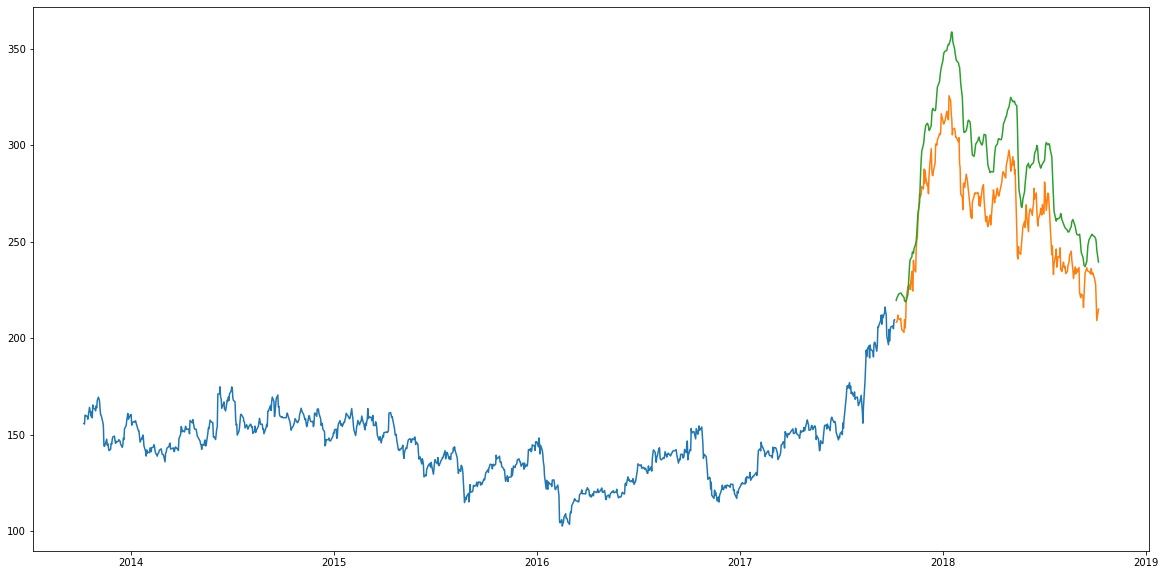

In [59]:
#for plotting
#الان سنقوم بتخطيط البيانات الأساسية والفعلية والبيانات التي تم توقعها بأستخدام النموذج.
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])